In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.stats
import collections
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
seed = 23

def calculate_entropy(list_values):
    counter_values = collections.Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(np.array(list_values)**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values)>np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics


In [2]:
def main(data,cond,wav):
    
    # Putting all the samples in an array
    array=np.array(data.Samples)
    
    # Defining Wavelet 
    w = pywt.Wavelet(wav)

    # Getting Approximation Coefficients
    lst_A_coeff = []
    max_levels = pywt.dwt_max_level(len(array),wav)
    
    for i in range(1, max_levels + 1):
        temp = pywt.wavedec(pd.Series(array), wav, mode="per",level=i)
        lst_A_coeff.append(temp[0])
    
    
    # Feature Extraction From Approximation Coefficients
    feature_list=[]
    for i in range(0,max_levels):
        feature_list.append(get_features(list(lst_A_coeff[i])))
        
    flr=[]
    for j in range(0,12):
        temp_lst=[]
        for i in range(0,max_levels):
            temp_lst.append(feature_list[i][j])
        flr.append(temp_lst)

    
    dic={'Entropy':flr[0],'Zero crossings':flr[1],'Mean crossings':flr[2],'n5':flr[3],
    'n25':flr[4],'n75':flr[5],'n95':flr[6],'Median':flr[7],'Mean':flr[8],
    'Std':flr[9],'Var':flr[10],'Rms':flr[11]}
    
    dataframe=pd.DataFrame(dic)
    dataframe["Condition"]=cond
    return dataframe



file_names=["Motor (Healthy 450W).csv","Motor (Healthy 600W).csv","Motor (Healthy 760W).csv","Motor (Healthy 1100W).csv","Motor (Healthy 1500W).csv",
            "Motor 1(Healthy) 50% load.csv","Motor 1(Healthy) 80% load.csv","Motor 1(Healthy) 90% load.csv","Motor 2(Healthy) 50% load.csv","Motor 2(Healthy) 80% load.csv",
            "Motor 2(Healthy) 90% load.csv","Motor 1(BRB 450W).csv","Motor 1(BRB 600W).csv","Motor 1(BRB 50% load).csv","Motor 1(BRB 1000W).csv","Motor 1(BRB 1100W).csv","Motor 1(BRB 80% load).csv",
            "Motor 1(BRB 90% load).csv","Motor 1(BRB 1500W).csv","Motor 2(BF 50% load).csv","Motor 2(BF 80% load).csv","Motor 2(BF 90% load).csv",
            "Motor 2(BF 600W).csv","Motor 2(BF 1000W).csv"]

condition=[0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2]
data_frames=[]

pred_lst_1=[]
pred_lst_2=[]
pred_lst_3=[]
model_lst_2=[]
for wavlet in pywt.wavelist(kind="discrete"):
    for i in range(0,24):
        data=pd.read_csv(file_names[i])
        data_frames.append(main(data,condition[i],wavlet))

    pd.options.display.max_columns=150
    pd.options.display.max_rows=150
    dataframe= pd.concat([i for i in data_frames],axis=0,ignore_index=True)
    
    dataframe.drop(["Entropy","Zero crossings","Mean crossings"],axis=1,inplace=True)
    X = dataframe[["n5","n25","n75","n95","Std","Var","Rms","Median","Mean"]]
    dataframe.drop(["Median","Mean","n5","n25","n75","n95","Std","Var","Rms"],axis=1,inplace=True)
    pca = PCA(n_components=4)
    components = pca.fit_transform(X)
    principal_df = pd.DataFrame(data = components,columns = ['principal component 1',
                                                             'principal component 2',
                                                             'principal component 3',
                                                             'principal component 4'])
    df= pd.concat([principal_df,dataframe],axis=1,ignore_index=True)
    df.rename(columns={0:"PC1",1:"PC2",2:"PC3",3:"PC4",4:"Condition"},inplace=True)
    test_size = 0.20
    X=df.loc[:,"PC1":"PC4"]
    Y=df.loc[:,"Condition"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    # XGBoost
    model_1 = XGBClassifier(learning_rate=0.01,objective="multi:softprob",n_estimators=500,booster="gbtree")
    model_1.fit(X_train, Y_train, eval_metric="error", verbose=True)

    # make predictions for test data
    y_pred_1 = model_1.predict(X_test)
    predictions_1 = [(value) for value in y_pred_1]

    # evaluate predictions
    pred_lst_1.append((accuracy_score(Y_test, predictions_1))*100)
    
    # KNN classifier
    model_2= KNeighborsClassifier(algorithm='auto',leaf_size= 1,metric='minkowski',n_neighbors=7,weights='distance')
    model_2.fit(X_train, Y_train)
    
    # make predictions for test data
    y_pred_2 = model_2.predict(X_test)
    model_lst_2.append(model_2)
    predictions_2 = [(value) for value in y_pred_2]
    
    # evaluate predictions
    pred_lst_2.append((accuracy_score(Y_test, predictions_2))*100)
    
    # Logistic Regression
    model_3 = LogisticRegression(max_iter=200000)
    model_3.fit(X_train, Y_train)
    
    # make predictions for test data
    y_pred_3 = model_3.predict(X_test)
    predictions_3 = [(value) for value in y_pred_3]

    # evaluate predictions
    pred_lst_3.append((accuracy_score(Y_test, predictions_3))*100)
    

In [3]:
di = {"XGB Classifier":pred_lst_1,"KNN Classifier":pred_lst_2}
comp_df= pd.DataFrame(di)
comp_df.index=pywt.wavelist(kind="discrete")

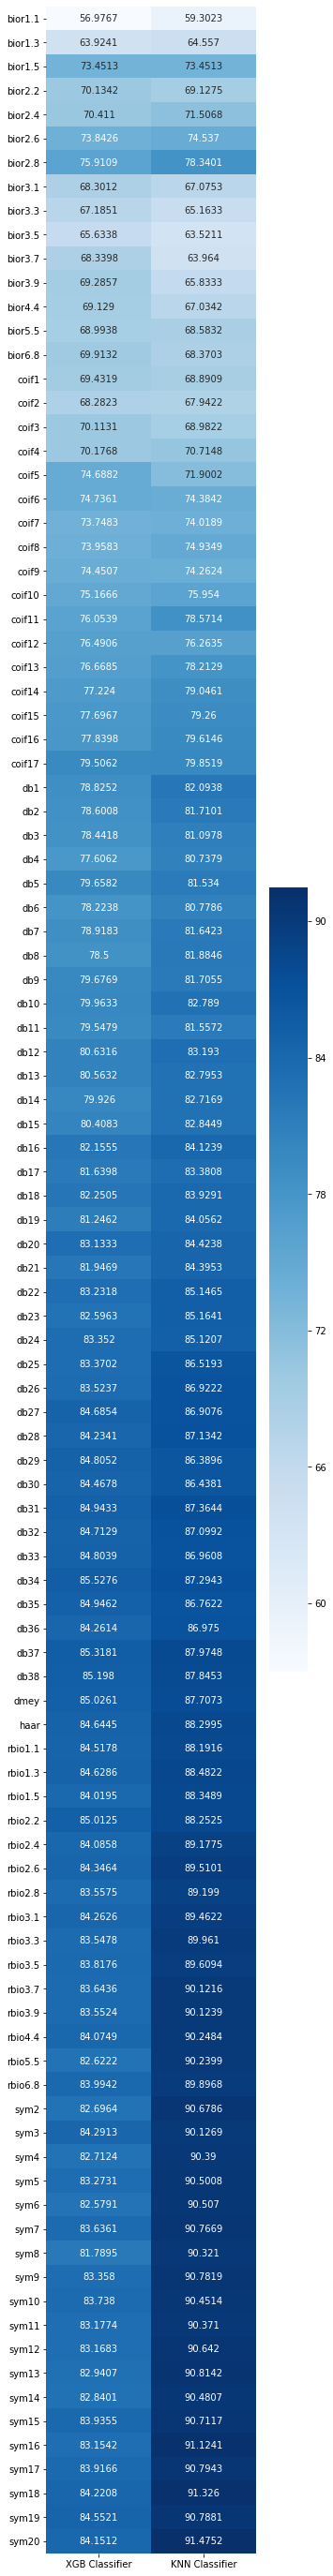

In [4]:
plt.figure(figsize=(5,50))
heatmap = sns.heatmap(comp_df, annot=True, linewidths=0, cmap="Blues",fmt="g")

In [23]:
figure = heatmap.get_figure()    
figure.savefig('svm_conf_new.png', dpi=400)

In [13]:
best_model=model_lst_2[-1]
# make predictions for test data
y_pred = best_model.predict(X_test)
predictions = [(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.48%


In [10]:
result = pd.DataFrame(data={"Actual Condition":Y_test,"Predicted Condition":predictions})
result.reset_index(drop=True,inplace=True)

In [12]:
result.to_csv("result.csv",index=False)